In [1]:
import sys
sys.path.append("../")

import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

import ta

In [2]:
pair='BTCUSDT'
granularity = '1m'

In [3]:
df = pd.read_pickle(f"../crypto/{pair}_{granularity}.pkl")

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
df.head()

,Time,Open,High,Low,Close,Volume
0,2019-01-01 00:00:00,3701.23,3703.72,3701.09,3702.46,17.100110
1,2019-01-01 00:01:00,3702.44,3702.63,3695.66,3697.04,23.700604
2,2019-01-01 00:02:00,3699.42,3702.04,3696.08,3698.14,14.488615
3,2019-01-01 00:03:00,3697.49,3698.19,3695.97,3696.51,8.499966
4,2019-01-01 00:04:00,3697.20,3697.62,3695.00,3696.32,21.782886


In [6]:
df['time'] = df['Time']

In [7]:
import pandas as pd

def calculate_pivot_points(df, period=2):
    """
    Calcula os níveis de suporte e resistência baseados em Pivot Points, de forma vetorizada.
    
    Args:
        df (pd.DataFrame): DataFrame contendo as colunas 'High', 'Low', 'Close'.
        period (int): Período para calcular os pivots.

    Returns:
        pd.DataFrame: DataFrame atualizado com colunas Pivot, Resistance1, Resistance2, Support1, Support2.
    """
    rolling_high = df['High'].rolling(window=period, min_periods=1).max()
    rolling_low = df['Low'].rolling(window=period, min_periods=1).min()
    rolling_close = df['Close'].rolling(window=period, min_periods=1).mean()

    df['Pivot'] = (rolling_high + rolling_low + rolling_close) / 3
    df['Resistance1'] = (2 * df['Pivot']) - rolling_low
    df['Support1'] = (2 * df['Pivot']) - rolling_high
    df['Resistance2'] = df['Pivot'] + (rolling_high - rolling_low)
    df['Support2'] = df['Pivot'] - (rolling_high - rolling_low)
    
    return df



In [8]:
def calculate_supertrend(df, atr_multiplier=3, atr_period=15):
    """
    Cálculo básico do SuperTrend para um DataFrame já consolidado.

    Args:
        df (pd.DataFrame): DataFrame contendo 'High', 'Low', e 'Close'.
        atr_multiplier (float): Multiplicador para o cálculo das bandas.
        atr_period (int): Período para o cálculo do ATR.

    Returns:
        pd.DataFrame: DataFrame com colunas adicionais para SuperTrend, Upperband e Lowerband.
    """
    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=atr_period)

    # Cálculo das bandas básicas
    avg_high_low = (df['High'] + df['Low']) / 2
    df['BasicUpperband'] = avg_high_low + (atr_multiplier * df['ATR'])
    df['BasicLowerband'] = avg_high_low - (atr_multiplier * df['ATR'])

    basic_upperband = df['BasicUpperband'].values
    basic_lowerband = df['BasicLowerband'].values
    
    # Inicializar listas para bandas superiores e inferiores ajustadas
    upper_band = [df['BasicUpperband'].iloc[0]]
    lower_band = [df['BasicLowerband'].iloc[0]]
    
    # Ajustar bandas com base nas condições de cruzamento
    for i in range(1, len(df)):
        # Ajuste da banda superior
        if (basic_upperband[i] < upper_band[i - 1]) or (df['Close'].iloc[i - 1] > upper_band[i - 1]):
            upper_band.append(basic_upperband[i])
        else:
            upper_band.append(upper_band[i - 1])

        # Ajuste da banda inferior
        if (basic_lowerband[i] > lower_band[i - 1]) or (df['Close'].iloc[i - 1] < lower_band[i - 1]):
            lower_band.append(basic_lowerband[i])
        else:
            lower_band.append(lower_band[i - 1])

    # Adicionar bandas ajustadas ao DataFrame
    df['Upperband'] = upper_band
    df['Lowerband'] = lower_band

    # Determinar a tendência e o SuperTrend
    trend = [1]  # Inicializando tendência: 1 = Alta, -1 = Baixa
    supertrend = [df['Upperband'].iloc[0]]  # Inicializando SuperTrend

    close = df['Close'].values
    
    for i in range(1, len(df)):
        # Atualizar tendência
        if trend[i - 1] == 1 and close[i] < lower_band[i]:
            trend.append(-1)
        elif trend[i - 1] == -1 and close[i] > upper_band[i]:
            trend.append(1)
        else:
            trend.append(trend[i - 1])

        # Atualizar SuperTrend
        if trend[i] == -1:
            supertrend.append(upper_band[i])
        else:
            supertrend.append(lower_band[i])

    df['Trend'] = trend
    df['SuperTrend'] = supertrend

    # Remover colunas temporárias
    df.drop(['BasicUpperband', 'BasicLowerband'], axis=1, inplace=True)

    return df


def supertrend(df, atr_multiplier=3, atr_period=15, new_timeframe=1):
    """
    Método principal para calcular o SuperTrend com suporte a timeframes maiores.

    Args:
        df (pd.DataFrame): DataFrame contendo 'High', 'Low', e 'Close'.
        atr_multiplier (float): Multiplicador para o cálculo das bandas.
        atr_period (int): Período para o cálculo do ATR.
        new_timeframe (int): Número de candles para consolidar (ex: 60 para 1 hora em candles de 1 minuto).

    Returns:
        pd.DataFrame: DataFrame original com colunas adicionais para SuperTrend.
    """
    if new_timeframe > 1:
        # Agrupar os dados
        df_grouped = df.copy()
        df_grouped['group'] = (df_grouped.index // new_timeframe)
        
        grouped = df_grouped.groupby('group').agg({
            'High': 'max',
            'Low': 'min',
            'Close': 'last'
        }).reset_index(drop=True)
        
        # Calcular o SuperTrend no timeframe agrupado
        grouped = calculate_supertrend(grouped, atr_multiplier=atr_multiplier, atr_period=atr_period)
        
        # Interpolar os valores calculados para o dataframe original
        df[f'Upperband_{new_timeframe}'] = grouped['Upperband'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'Lowerband_{new_timeframe}'] = grouped['Lowerband'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'Trend_{new_timeframe}'] = grouped['Trend'].repeat(new_timeframe).iloc[:len(df)].values
        df[f'SuperTrend_{new_timeframe}'] = grouped['SuperTrend'].repeat(new_timeframe).iloc[:len(df)].values
    else:
        # Calcular o SuperTrend no timeframe original
        df = calculate_supertrend(df, atr_multiplier=atr_multiplier, atr_period=atr_period)

    return df


In [9]:
df.head()

,Time,Open,High,Low,Close,Volume,time
0,2019-01-01 00:00:00,3701.23,3703.72,3701.09,3702.46,17.100110,2019-01-01 00:00:00
1,2019-01-01 00:01:00,3702.44,3702.63,3695.66,3697.04,23.700604,2019-01-01 00:01:00
2,2019-01-01 00:02:00,3699.42,3702.04,3696.08,3698.14,14.488615,2019-01-01 00:02:00
3,2019-01-01 00:03:00,3697.49,3698.19,3695.97,3696.51,8.499966,2019-01-01 00:03:00
4,2019-01-01 00:04:00,3697.20,3697.62,3695.00,3696.32,21.782886,2019-01-01 00:04:00


In [10]:
# Calcular o SuperTrend com agrupamento de 60 candles (1 hora em candles de 1 minuto)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=720)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=360)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=180)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=120)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=60)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=30)
df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=15)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=5)
# df_with_supertrend = supertrend(df, atr_multiplier=3, atr_period=10, new_timeframe=1)


In [11]:
df_with_supertrend.head()

,Time,Open,High,Low,Close,Volume,time,Upperband_15,Lowerband_15,Trend_15,SuperTrend_15
0,2019-01-01 00:00:00,3701.23,3703.72,3701.09,3702.46,17.100110,2019-01-01 00:00:00,3696.8,3696.8,1,3696.8
1,2019-01-01 00:01:00,3702.44,3702.63,3695.66,3697.04,23.700604,2019-01-01 00:01:00,3696.8,3696.8,1,3696.8
2,2019-01-01 00:02:00,3699.42,3702.04,3696.08,3698.14,14.488615,2019-01-01 00:02:00,3696.8,3696.8,1,3696.8
3,2019-01-01 00:03:00,3697.49,3698.19,3695.97,3696.51,8.499966,2019-01-01 00:03:00,3696.8,3696.8,1,3696.8
4,2019-01-01 00:04:00,3697.20,3697.62,3695.00,3696.32,21.782886,2019-01-01 00:04:00,3696.8,3696.8,1,3696.8


In [12]:
# plot_df = df_with_supertrend.iloc[:20000]

# cp = CandlePlot(plot_df, candles=False)
# cp.show_plot(line_traces = ['Close','SuperTrend_15'],
#              # sec_traces=['trend'],
#              height=1000, width=1100)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def analisar_distribuicao_e_plotar(df, coluna='Close', k=1, remover_outliers=True):
    """
    Analisa a distribuição normal das variações percentuais, inclui porcentagens no gráfico e remove outliers.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os preços.
        coluna (str): Nome da coluna com os preços de fechamento.
        k (float): Fator multiplicador para definir os limites (kσ).
                   - Exemplo de valores e implicações:
                     - k=1: Captura aproximadamente 68% dos dados (limite ±1σ).
                     - k=2: Captura aproximadamente 95% dos dados (limite ±2σ).
                     - k=3: Captura aproximadamente 99.7% dos dados (limite ±3σ).
        remover_outliers (bool): Se True, remove valores fora dos limites definidos por kσ.
    """
    # Calcular variação percentual
    df['var_percentual'] = df[coluna].pct_change() * 100
    variacoes = df['var_percentual'].dropna()
    
    # Calcular média e desvio padrão
    media = variacoes.mean()
    desvio_padrao = variacoes.std()

    k=0.5
    # Definir limites baseado no multiplicador k
    limite_alta = media + k * desvio_padrao
    limite_baixa = media - k * desvio_padrao
    
    # Remover outliers, se ativado
    if remover_outliers:
        variacoes = variacoes[(variacoes >= 5*limite_baixa) & (variacoes <= 5*limite_alta)]
    
    # Gerar dados para a curva normal
    x = np.linspace(variacoes.min(), variacoes.max(), 1000)
    curva = norm.pdf(x, media, desvio_padrao)
    
    # Plotar histograma e curva
    plt.figure(figsize=(12, 6))
    plt.hist(variacoes, bins=30, density=True, alpha=0.6, color='skyblue', label='Histograma')
    plt.plot(x, curva, color='red', label='Distribuição Normal')
    
    # Adicionar linhas verticais para média e desvios padrão
    plt.axvline(media, color='black', linestyle='--', label='Média (μ)')
    plt.axvline(media + k * desvio_padrao, color='green', linestyle='--', label=f'+{k}σ ({limite_alta:.2f})')
    plt.axvline(media - k * desvio_padrao, color='green', linestyle='--', label=f'-{k}σ ({limite_baixa:.2f})')
    plt.axvline(media + 2 * desvio_padrao, color='orange', linestyle='--', label=f'+2σ ({media + 2 * desvio_padrao:.2f})')
    plt.axvline(media - 2 * desvio_padrao, color='orange', linestyle='--', label=f'-2σ ({media - 2 * desvio_padrao:.2f})')
    plt.axvline(media + 3 * desvio_padrao, color='purple', linestyle='--', label=f'+3σ ({media + 3 * desvio_padrao:.2f})')
    plt.axvline(media - 3 * desvio_padrao, color='purple', linestyle='--', label=f'-3σ ({media - 3 * desvio_padrao:.2f})')
    
    # Adicionar texto explicativo das porcentagens
    plt.text(media, 0.02, f"68%", color='green', fontsize=10, ha='center')
    plt.text(media + 1.5 * desvio_padrao, 0.01, "95%", color='orange', fontsize=10, ha='center')
    plt.text(media + 2.5 * desvio_padrao, 0.005, "99.7%", color='purple', fontsize=10, ha='center')
    
    # Configurar título e legendas
    plt.title(f'Distribuição Normal das Variações Percentuais com k={k}')
    plt.xlabel('Variação Percentual (%)')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()
    
    # Retornar estatísticas
    return {
        'media': media,
        'desvio_padrao': desvio_padrao,
        'limite_alta': limite_alta,
        'limite_baixa': limite_baixa
    }




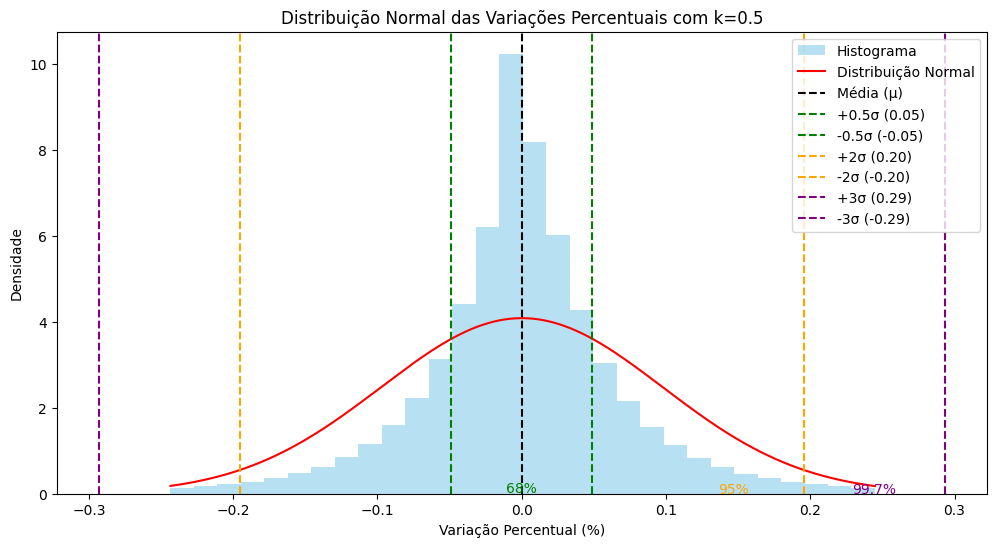

{'media': np.float64(0.00014171851794413703),
 'desvio_padrao': np.float64(0.09766846138579385),
 'limite_alta': np.float64(0.048975949210841065),
 'limite_baixa': np.float64(-0.04869251217495279)}

In [14]:
df = df_with_supertrend.copy()
# Exemplo de uso
# Suponha que você tenha um DataFrame `df` com uma coluna 'Close'
analisar_distribuicao_e_plotar(df)

In [15]:
def classificar_variacao_com_distribuicao(var, media, desvio_padrao):
    limite_alta = media + 0.5*desvio_padrao
    limite_baixa = media - 0.5*desvio_padrao
    
    if var > limite_alta:
        return "Alta"
    elif var < limite_baixa:
        return "Baixa"
    elif var < limite_alta and var > 0:
        return "Leve Alta"
    elif var > limite_baixa and var <= 0:
        return "Leve Baixa"

# Calcular variação percentual
df['var_percentual'] = df['Close'].pct_change() * 100
variacoes = df['var_percentual'].dropna()

# Calcular média e desvio padrão
media = variacoes.mean()
desvio_padrao = variacoes.std()

df['classificacao'] = df['var_percentual'].apply(
    lambda var: classificar_variacao_com_distribuicao(var, media, desvio_padrao)
)




In [16]:
df.classificacao.value_counts()

classificacao
Leve Baixa    965990
Leve Alta     920446
Baixa         567808
Alta          565644
Name: count, dtype: int64

In [17]:
def calcular_classificacao_por_janela(df, coluna_close='Close', janela=10, limite=2):
    """
    Calcula a classificação da variação percentual com base nos últimos `janela` candles.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os preços.
        coluna_close (str): Nome da coluna com os preços de fechamento.
        janela (int): Número de candles para calcular a variação percentual.
        limite (float): Multiplicador do desvio padrão para definir os limites de classificação.

    Retorna:
        list: Lista com as classificações ('Alta', 'Baixa', 'Leve Alta', 'Leve Baixa') para cada candle.
    """
    classificacoes = []
    variacoes_list = []

    # Criar o novo timeframe (preço de fechamento do último candle em cada janela)
    agrupado = df[coluna_close].groupby(df.index // janela).last()
    
    # Calcular variações percentuais do novo timeframe
    variacoes = agrupado.pct_change() * 100  # Variação percentual entre os novos candles
    media = variacoes.mean()
    desvio_padrao = variacoes.std()

    close = df[coluna_close].values
    
    for i in range(len(df)):
        if i < janela:  # Não é possível calcular para os primeiros `janela` candles
            classificacoes.append(None)
            variacoes_list.append(None)
            continue
        
        # Calcular a variação percentual entre o primeiro e o último candle da janela
        preco_inicial = close[i - janela]
        preco_final = close[i]
        variacao = (preco_final - preco_inicial) / preco_inicial * 100

        # Classificar com base nos limites
        limite_alta = media + limite * desvio_padrao
        limite_baixa = media - limite * desvio_padrao
        if variacao > limite_alta:
            classificacoes.append('Alta')
            variacoes_list.append(variacao)
        elif variacao < limite_baixa:
            classificacoes.append('Baixa')
            variacoes_list.append(variacao)
        elif variacao > 0:
            classificacoes.append('Leve Alta')
            variacoes_list.append(variacao)
        else:
            classificacoes.append('Leve Baixa')
            variacoes_list.append(variacao)
    
    return classificacoes, variacoes_list



In [18]:
df['classificacao_x'], df['variacao_x'] = calcular_classificacao_por_janela(df, coluna_close='Close', janela=500, limite=0.5)
df['classificacao_n'], df['variacao_n'] = calcular_classificacao_por_janela(df, coluna_close='Close', janela=200, limite=0.5)
df['classificacao_p'], df['variacao_p'] = calcular_classificacao_por_janela(df, coluna_close='Close', janela=100, limite=0.5)
df['classificacao_z'], df['variacao_z'] = calcular_classificacao_por_janela(df, coluna_close='Close', janela=60, limite=0.5)

In [19]:
df.tail()

,Time,Open,High,Low,Close,Volume,time,Upperband_15,Lowerband_15,Trend_15,...,var_percentual,classificacao,classificacao_x,variacao_x,classificacao_n,variacao_n,classificacao_p,variacao_p,classificacao_z,variacao_z
3019884,2024-09-30 23:55:00,63288.20,63332.63,63288.19,63318.01,11.70012,2024-09-30 23:55:00,63760.926833,62546.094351,-1,...,0.047102,Leve Alta,Leve Baixa,-0.637887,Baixa,-0.615272,Baixa,-0.515350,Leve Baixa,-0.350045
3019885,2024-09-30 23:56:00,63318.01,63356.65,63310.00,63324.99,9.29110,2024-09-30 23:56:00,63760.926833,62546.094351,-1,...,0.011024,Leve Alta,Leve Baixa,-0.633170,Baixa,-0.621896,Baixa,-0.462126,Leve Baixa,-0.307006
3019886,2024-09-30 23:57:00,63324.99,63352.00,63324.99,63338.00,7.18517,2024-09-30 23:57:00,63760.926833,62546.094351,-1,...,0.020545,Leve Alta,Leve Baixa,-0.546415,Leve Baixa,-0.593289,Baixa,-0.444743,Leve Baixa,-0.237805
3019887,2024-09-30 23:58:00,63337.99,63356.00,63337.99,63348.00,6.83506,2024-09-30 23:58:00,63760.926833,62546.094351,-1,...,0.015788,Leve Alta,Leve Baixa,-0.568200,Leve Baixa,-0.556977,Leve Baixa,-0.371742,Leve Baixa,-0.215878
3019888,2024-09-30 23:59:00,63348.01,63359.05,63327.59,63327.59,10.82416,2024-09-30 23:59:00,63760.926833,62546.094351,-1,...,-0.032219,Leve Baixa,Leve Baixa,-0.537304,Baixa,-0.616584,Baixa,-0.453329,Leve Baixa,-0.243203


In [20]:

def calcular_alvo_candle(df, coluna_close='Close', coluna_high='High', coluna_low='Low', n=5, limite=2):
    """
    Calcula os alvos para cada candle baseado em uma janela de n candles, considerando High, Low e Close.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os preços.
        coluna_close (str): Nome da coluna com os preços de fechamento.
        coluna_high (str): Nome da coluna com os preços máximos.
        coluna_low (str): Nome da coluna com os preços mínimos.
        n (int): Janela de candles para análise do alvo.
        limite (float): Percentual limite para classificar os alvos (ex.: 2%).

    Retorna:
        list: Lista com os alvos (`PS`, `NS`, `EA`, `EB`) para cada candle.
    """
    alvos = []
    variacoes = df[coluna_close].pct_change() * 100  # Variação percentual entre candles

    close = df[coluna_close].values
    high = df[coluna_high].values
    low = df[coluna_low].values
    
    for i in range(len(df)):
        if i + n >= len(df):  # Não é possível calcular para as últimas janelas incompletas
            alvos.append(None)
            continue

        # Valor de fechamento atual como referência
        close_atual = close[i]

        janela = variacoes[i + 1:i + n + 1]  # Próximos n candles
        
        # # Calcular variações percentuais máximas e mínimas usando High e Low em relação ao Close atual
        # janela_high = high[i + 1:i + n + 1]
        # janela_low = low[i + 1:i + n + 1]

        # max_alta = (janela_high.max() - close_atual) / close_atual * 100
        # max_baixa = (janela_low.min() - close_atual) / close_atual * 100

        # Classificar os alvos com base nos limites
        # if max_alta >= limite:  # Subiu 2% ou mais
        #     alvos.append('EA')
        # elif max_baixa <= -limite:  # Caiu 2% ou mais
        #     alvos.append('EB')
        if janela.sum() < 0:
            alvos.append('NS')
        else:  # Percentual negativo sem ultrapassar limite
            alvos.append('PS')
        
    return alvos

df['alvos'] = calcular_alvo_candle(df, coluna_close='Close', coluna_high='High', coluna_low='Low', n=60, limite=0.5)

In [21]:
df.alvos.value_counts()

alvos
PS    1539680
NS    1480149
Name: count, dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
df.tail()

,Time,Open,High,Low,Close,Volume,time,Upperband_15,Lowerband_15,Trend_15,...,classificacao,classificacao_x,variacao_x,classificacao_n,variacao_n,classificacao_p,variacao_p,classificacao_z,variacao_z,alvos
3019824,2024-09-30 22:55:00,63559.99,63559.99,63538.01,63540.43,2.69986,2024-09-30 22:55:00,63959.440245,63238.044176,-1,...,Leve Baixa,Leve Baixa,-0.472385,Leve Alta,0.259467,Leve Baixa,-0.319965,Leve Baixa,-0.256734,NS
3019825,2024-09-30 22:56:00,63540.44,63540.44,63519.99,63520.00,10.18758,2024-09-30 22:56:00,63959.440245,63238.044176,-1,...,Leve Baixa,Leve Baixa,-0.591568,Leve Alta,0.091583,Leve Baixa,-0.352015,Leve Baixa,-0.315344,NS
3019826,2024-09-30 22:57:00,63520.00,63520.00,63488.98,63488.98,9.65171,2024-09-30 22:57:00,63959.440245,63238.044176,-1,...,Baixa,Leve Baixa,-0.624562,Leve Baixa,-0.023274,Leve Baixa,-0.400694,Baixa,-0.383738,NS
3019827,2024-09-30 22:58:00,63488.99,63506.00,63480.00,63485.05,5.96587,2024-09-30 22:58:00,63959.440245,63238.044176,-1,...,Leve Baixa,Leve Baixa,-0.661795,Leve Alta,0.001670,Leve Baixa,-0.426760,Leve Baixa,-0.350535,NS
3019828,2024-09-30 22:59:00,63485.05,63489.36,63480.00,63481.98,15.08906,2024-09-30 22:59:00,63959.440245,63238.044176,-1,...,Leve Baixa,Leve Baixa,-0.753580,Leve Alta,0.022027,Leve Baixa,-0.397144,Baixa,-0.353101,NS


In [122]:
def criar_tuplas(df, coluna='classificacao', coluna_alvo='alvos'):
    """
    Cria tuplas de 3 estados consecutivos e adiciona os 2 próximos estados como alvo.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados classificados.
        coluna (str): Nome da coluna com as classificações (Alta, Baixa).

    Retorna:
        list: Lista de tuplas no formato [(estado_atual, alvo), ...].
    """

    # trend_1 = df['Trend'].values
    # trend_5 = df['Trend_5'].values
    trend_15 = df['Trend_15'].values
    # trend_30 = df['Trend_30'].values
    # trend_60 = df['Trend_60'].values
    # trend_120 = df['Trend_120'].values
    # trend_180 = df['Trend_180'].values
    # trend_360 = df['Trend_360'].values
    # trend_720 = df['Trend_720'].values
    
    alvos = df[coluna_alvo].values
    estados = df[coluna].values
    estados_x = df['classificacao_x'].values
    estados_n = df['classificacao_n'].values
    estados_p = df['classificacao_p'].values
    estados_z = df['classificacao_z'].values
    
    tuplas = []

    for i in range(1,len(estados)):
        if trend_15[i-1] != trend_15[i]:
            estado_atual = (
                # estados_x[i],
                # estados_n[i],
                # estados_p[i], 
                # estados_z[i], 
                # int(trend_720[i]),int(trend_360[i]),
                # int(trend_180[i]),
                # int(trend_120[i]),            
                # int(trend_60[i]),
                # int(trend_30[i]),
                int(trend_15[i]),
                # int(trend_5[i])
                # int(trend_1[i])
            )
            alvo = alvos[i]  # Próximos 2 estados
            tuplas.append((estado_atual, alvo))
        else:
            tuplas.append(None)
    return tuplas



In [123]:

from sklearn.model_selection import train_test_split

# Divisão do DataFrame
df_treino, df_teste = train_test_split(df, test_size=0.2, shuffle=False)

# Criar tuplas de 3 estados para treinamento e teste
tuplas_treino = criar_tuplas(df_treino)
tuplas_teste = criar_tuplas(df_teste)


df_treino['tuplas'] = [None] * len(df_treino)  # Inicializar a coluna com None
tt = [None]+tuplas_treino
df_treino['tuplas'] = tt  # Preencher as tuplas a partir da 3ª linha (índice 2)

df_treino.shape

(2415463, 23)

In [124]:
df_treino.dropna(inplace=True)

df_treino.shape

(3337, 23)

In [125]:
# df_treino.head(50)[['Close','var_percentual','classificacao','classificacao_n','variacao_n','classificacao_x','variacao_x','alvos','tuplas']]

In [126]:

# Contar frequência de cada tupla
from collections import Counter
tupla_frequencias = Counter(tuplas_treino)

# Exibir as tuplas mais frequentes
print("Tuplas mais frequentes:")
for tupla, frequencia in tupla_frequencias.most_common(1000):
    print(f"{tupla}: {frequencia}")


Tuplas mais frequentes:
None: 2412125
((1,), 'PS'): 1299
((-1,), 'NS'): 1283
((-1,), 'PS'): 386
((1,), 'NS'): 369


In [127]:
from collections import Counter

# Extrair apenas os estados atuais (primeiro elemento da tupla)
estados_atuais = []
for tuplas in tuplas_treino:
    if tuplas != None:
        estados_atuais.append(tuplas[0])

# Contar a frequência de cada estado atual
estado_frequencias = Counter(estados_atuais)

# Exibir os estados mais frequentes
print("Estados mais frequentes:")
for estado, frequencia in estado_frequencias.most_common(1000):
    print(f"{estado}: {frequencia}")

Estados mais frequentes:
(-1,): 1669
(1,): 1668


In [128]:
def montar_matriz_transicao(tuplas):
    """
    Monta a matriz de transição baseada em tuplas com 3 estados e 2 estados como alvo.

    Parâmetros:
        tuplas (list): Lista de tuplas no formato [(estado_atual, alvo), ...].

    Retorna:
        dict: Matriz de transição representada como um dicionário.
    """
    # Criar dicionário para contar as transições
    transicoes = {}
    for tupla in tuplas:
        if tupla != None:
            estado_atual, alvo = tupla
            if estado_atual not in transicoes:
                transicoes[estado_atual] = {}
            if alvo not in transicoes[estado_atual]:
                transicoes[estado_atual][alvo] = 0
            transicoes[estado_atual][alvo] += 1

    # Normalizar para obter probabilidades
    matriz_transicao = {}
    for estado_atual, transicoes_proximas in transicoes.items():
        total_transicoes = sum(transicoes_proximas.values())
        matriz_transicao[estado_atual] = {
            alvo: count / total_transicoes
            for alvo, count in transicoes_proximas.items()
        }
    
    return matriz_transicao


In [129]:
# Montar a matriz de transição com as tuplas
matriz_transicao = montar_matriz_transicao(tuplas_treino)

In [132]:
def filtrar_transicoes_por_limiar(matriz_transicao, limiar):
    """
    Filtra os estados atuais e seus alvos na matriz de transição que têm probabilidade acima do limiar.

    Parâmetros:
        matriz_transicao (dict): Matriz de transição representada como um dicionário.
        limiar (float): Limiar de probabilidade para filtrar as transições.

    Retorna:
        dict: Estados atuais e seus alvos que atendem ao critério.
    """
    transicoes_filtradas = {}
    
    for estado_atual, transicoes in matriz_transicao.items():
        for alvo, probabilidade in transicoes.items():
            if probabilidade > limiar:
                if estado_atual not in transicoes_filtradas:
                    transicoes_filtradas[estado_atual] = {}
                transicoes_filtradas[estado_atual][alvo] = probabilidade

    return transicoes_filtradas

# Exemplo de uso
limiar = 0.7  # Defina o limiar de probabilidade
transicoes_acima_limiar = filtrar_transicoes_por_limiar(matriz_transicao, limiar)

# Exibir resultados
for estado, alvos in transicoes_acima_limiar.items():
    for alvo, prob in alvos.items():
        print(f" Estado: {estado} | Alvo: {alvo} - Probabilidade: {prob:.2%}")


 Estado: (-1,) | Alvo: NS - Probabilidade: 76.87%
 Estado: (1,) | Alvo: PS - Probabilidade: 77.88%


In [133]:
# sum_acima_limir = 0
# # Exibir os estados mais frequentes
# print("Estados mais frequentes com filtro:")
# for estado, frequencia in estado_frequencias.most_common(1000):
#     if estado in list(transicoes_acima_limiar.keys()):
#         print(f"{estado}: {frequencia}")
#         sum_acima_limir += frequencia

# print(sum_acima_limir)


N =1  # Defina o limite mínimo de frequência
sum_acima_limir = 0

# Exibir os estados mais frequentes e remover os abaixo de N
print("Estados mais frequentes com filtro:")
for estado, frequencia in estado_frequencias.most_common(1000):
    if estado in list(transicoes_acima_limiar.keys()):
        if frequencia < N:
            del transicoes_acima_limiar[estado]  # Remove estado abaixo do limite
        else:
            print(f"{estado}: {frequencia}")
            sum_acima_limir += frequencia

print(sum_acima_limir)


Estados mais frequentes com filtro:
(-1,): 1669
(1,): 1668
3337


In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plotar_matriz_transicao_heatmap(matriz_transicao, titulo="Matriz de Transição com Alvos", largura=20, altura=15):
    """
    Plota um heatmap com a porcentagem de cada transição na matriz de transição com alvos.

    Parâmetros:
        matriz_transicao (dict): Matriz de transição representada como um dicionário.
        titulo (str): Título do gráfico.
        largura (int): Largura da figura.
        altura (int): Altura da figura.
    """
    # Transformar a matriz de transição em DataFrame para facilitar o plot
    data = []
    estados_origem = []
    estados_destino = []

    for estado_atual, transicoes in matriz_transicao.items():
        for alvo, probabilidade in transicoes.items():
            estados_origem.append(estado_atual)
            estados_destino.append(alvo)
            data.append(probabilidade)

    # Criar DataFrame
    df_transicao = pd.DataFrame({
        "Origem": estados_origem,
        "Destino": estados_destino,
        "Probabilidade": data
    })

    # Pivotar o DataFrame para formato adequado ao heatmap
    heatmap_data = df_transicao.pivot(
        index="Origem", 
        columns="Destino", 
        values="Probabilidade"
    ).fillna(0)

    # Plotar o heatmap
    plt.figure(figsize=(largura, altura))
    sns.heatmap(
        heatmap_data,
        annot=True,  # Exibir os valores
        fmt=".2%",   # Mostrar porcentagens
        cmap="Blues",  # Escolher esquema de cores
        cbar_kws={"label": "Probabilidade (%)"}  # Legenda do colorbar
    )

    # Configurações do gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel("Alvo (Próximos 2 Estados)", fontsize=12)
    plt.ylabel("Estado Atual (Últimos 3 Estados)", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Ajustar layout para evitar sobreposição
    plt.tight_layout()

    # Salvar a imagem como arquivo, se necessário
    plt.savefig("matriz_transicao_alvo_heatmap.png", dpi=300)
    print("Imagem salva como 'matriz_transicao_alvo_heatmap.png'")

    # Exibir o gráfico
    plt.show()


In [135]:
# plotar_matriz_transicao_heatmap(
#     matriz_transicao, 
#     titulo="Heatmap da Matriz de Transição",
#     largura=50,  # Aumentar a largura para visualizar melhor os números
#     altura=50    # Ajustar a altura conforme necessário
# )


In [136]:
def realizar_backtest(matriz_transicao, tuplas_teste, transicoes_acima_limiar = None):
    """
    Realiza um backtest com base na matriz de transição e tuplas de teste.

    Parâmetros:
        matriz_transicao (dict): Matriz de transição baseada nas tuplas de treinamento.
        tuplas_teste (list): Lista de tuplas com 3 estados consecutivos para teste.

    Retorna:
        dict: Métricas do backtest, como precisão.
    """
    acertos = 0
    total_transicoes = 0

    for i in range(len(tuplas_teste)):
        if tuplas_teste[i] != None:
            estado_atual = tuplas_teste[i][0]
            estado_real = tuplas_teste[i][1]
    
            if transicoes_acima_limiar and estado_atual not in list(transicoes_acima_limiar.keys()):
                continue
            
            if estado_atual in matriz_transicao:
                transicoes_proximas = matriz_transicao[estado_atual]
                if transicoes_proximas:
                    estado_previsto = max(transicoes_proximas, key=transicoes_proximas.get)  # Estado com maior probabilidade
                    if estado_previsto == estado_real:
                        acertos += 1
    
            total_transicoes += 1
        
    precisao = acertos / total_transicoes if total_transicoes > 0 else 0
    return {
        "acertos": acertos,
        "total": total_transicoes,
        "precisao": precisao
    }

# Realizar o backtest com a matriz de transição e tuplas de teste
resultados_backtest = realizar_backtest(matriz_transicao, tuplas_teste, transicoes_acima_limiar)
print("Resultados do Backtest:", resultados_backtest)


Resultados do Backtest: {'acertos': 755, 'total': 946, 'precisao': 0.7980972515856237}


In [137]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def realizar_backtest_com_matriz_confusao(matriz_transicao, tuplas_teste, transicoes_acima_limiar=None):
    """
    Realiza um backtest com base na matriz de transição e tuplas de teste e calcula a matriz de confusão.

    Parâmetros:
        matriz_transicao (dict): Matriz de transição baseada nas tuplas de treinamento.
        tuplas_teste (list): Lista de tuplas com 3 estados consecutivos para teste.
        transicoes_acima_limiar (dict): Transições filtradas por limiar (opcional).

    Retorna:
        dict: Métricas do backtest, incluindo matriz de confusão e relatório de classificação.
    """
    y_true = []
    y_pred = []

    for i in range(len(tuplas_teste)):
        if tuplas_teste[i] != None:
            estado_atual = tuplas_teste[i][0]
            estado_real = tuplas_teste[i][1]
    
            if transicoes_acima_limiar and estado_atual not in list(transicoes_acima_limiar.keys()):
                continue
    
            if estado_atual in matriz_transicao:
                transicoes_proximas = matriz_transicao[estado_atual]
                if transicoes_proximas:
                    estado_previsto = max(transicoes_proximas, key=transicoes_proximas.get)  # Estado com maior probabilidade
                    y_pred.append(estado_previsto)
                    y_true.append(estado_real)
                else:
                    y_pred.append(None)  # Caso não haja transição válida
                    y_true.append(estado_real)
            else:
                y_pred.append(None)  # Caso o estado atual não esteja na matriz
                y_true.append(estado_real)

    # Remover previsões e valores reais inválidos (None)
    y_true = [yt for yt, yp in zip(y_true, y_pred) if yt is not None and yp is not None]
    y_pred = [yp for yt, yp in zip(y_true, y_pred) if yt is not None and yp is not None]

    # Gerar matriz de confusão e relatório de classificação
    labels = list(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, target_names=[str(label) for label in labels])

    acertos = np.trace(cm)  # Soma da diagonal principal
    total = np.sum(cm)

    return {
        "acertos": acertos,
        "total": total,
        "precisao": acertos / total if total > 0 else 0,
        "matriz_confusao": cm,
        "rotulos": labels,
        "relatorio": report
    }

# Realizar o backtest com matriz de confusão
resultados_backtest = realizar_backtest_com_matriz_confusao(matriz_transicao, tuplas_teste, transicoes_acima_limiar)

# Exibir resultados
print("Resultados do Backtest:")
print(f"Precisão: {resultados_backtest['precisao']:.2%}")
print("Matriz de Confusão:")
print(resultados_backtest['matriz_confusao'])
print("\nRelatório de Classificação:")
print(resultados_backtest['relatorio'])


Resultados do Backtest:
Precisão: 79.81%
Matriz de Confusão:
[[381  99]
 [ 92 374]]

Relatório de Classificação:
              precision    recall  f1-score   support

          NS       0.81      0.79      0.80       480
          PS       0.79      0.80      0.80       466

    accuracy                           0.80       946
   macro avg       0.80      0.80      0.80       946
weighted avg       0.80      0.80      0.80       946

